In [31]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")

print(burglary_monthly)


C:\Users\gusta\AppData\Local\Temp\ipykernel_16564\142607075.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  burglary = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00
       Ward Code      Month  Count
0      E05009317 2013-12-01      8
1      E05009317 2014-01-01     23
2      E05009317 2014-02-01     12
3      E05009317 2014-03-01     11
4      E05009317 2014-04-01     21
...          ...        ...    ...
89633  E05014119 2024-10-01      1
89634  E05014119 2024-11-01      2
89635  E05014119 2024-12-01      4
89636  E05014119 2025-01-01      3
89637  E05014119 2025-02-01      4

[89638 rows x 3 columns]


In [32]:
# ## 2. SARIMA Forecasting for All Wards

import warnings

warnings.filterwarnings("ignore")

# Set manual orders for all wards
UNIVERSAL_ORDER = (3, 1, 1)
SEASONAL_ORDER = (3, 1, 1, 12)  # Monthly seasonality
TEST_MONTHS = 26

def analyze_ward(args):
    """Process a single ward with SARIMAX"""
    ward_code, ward_df = args
    try:
        # Prepare dataframe
        ward_df = ward_df[['Month', 'Count']].set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            ward_df.fillna(method='ffill', inplace=True)  # Forward-fill missing values
            # ward_df.fillna(method='bfill', inplace=True)  # Back-fill as a fallback

        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            return None

        # Split data
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]

        # Fit SARIMAX model
        model = SARIMAX(train,
                       order=UNIVERSAL_ORDER,
                       seasonal_order=SEASONAL_ORDER,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=TEST_MONTHS).predicted_mean

        # Calculate residuals
        residuals = test['Count'].values - preds.values

        print(f"{ward_code} completed")
        return {
            'ward_code': ward_code,
            'train_size': len(train),
            'test_size': len(test),
            'residuals': residuals,
            'predicted': preds.values,
            'actual': test['Count'].values,
            'model_summary': results.summary()
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# # Prepare arguments for multiprocessing
# args_list = [(code, group.copy())
#             for code, group in burglary_monthly.groupby('Ward Code')]
#
# # Process wards in parallel
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     results = pool.map(analyze_ward, args_list)
#
# # Filter successful results
# results = [res for res in results if res is not None]
# print(f"\nSuccessfully processed {len(results)} wards")

# Process all wards
results = []
# i = 0
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    analysis = analyze_ward((ward_code, group))
    if analysis:
        results.append(analysis)
    #     i += 1
    # if i > 3:
    #     break   # just to test a few wards, not all

# Remove None results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")

E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 completed
E05009327 completed
E05009328 has NaN values
E05009328 completed
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 completed
E05009386 completed
E05009387 has NaN values


Global MAE: 3.14
Global RMSE: 4.21
Mean Residual: 0.60
Positive Residuals: 55.2%


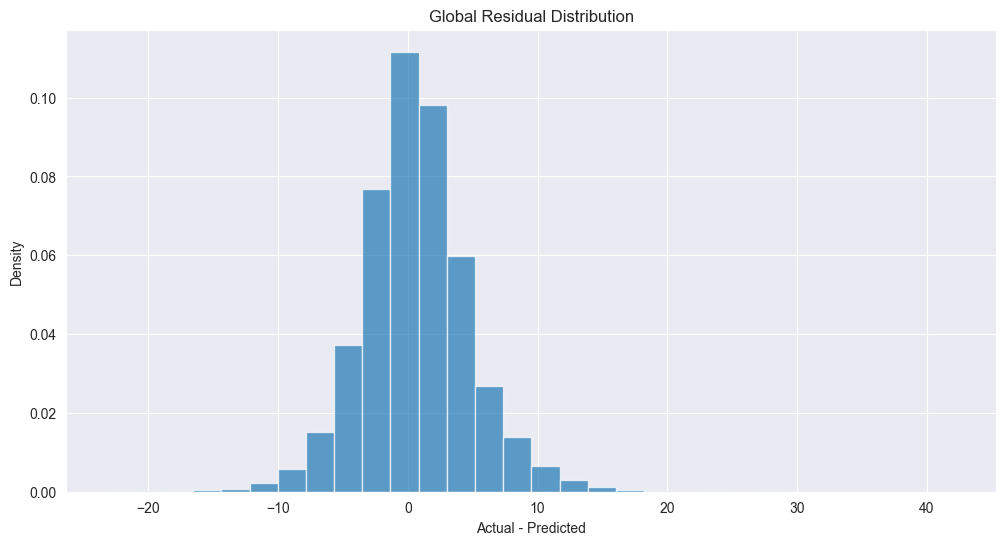

In [33]:
# Combine all residuals
all_residuals = np.concatenate([res['residuals'] for res in results])
all_predicted = np.concatenate([res['predicted'] for res in results])
all_actual = np.concatenate([res['actual'] for res in results])

# Overall metrics
print(f"Global MAE: {mean_absolute_error(all_actual, all_predicted):.2f}")
print(f"Global RMSE: {np.sqrt(mean_squared_error(all_actual, all_predicted)):.2f}")
print(f"Mean Residual: {np.mean(all_residuals):.2f}")
print(f"Positive Residuals: {np.mean(all_residuals > 0)*100:.1f}%")

# Residual distribution plot
plt.figure(figsize=(12, 6))
plt.hist(all_residuals, bins=30, density=True, alpha=0.7)
plt.title('Global Residual Distribution')
plt.xlabel('Actual - Predicted')
plt.ylabel('Density')
plt.grid(True)
plt.show()

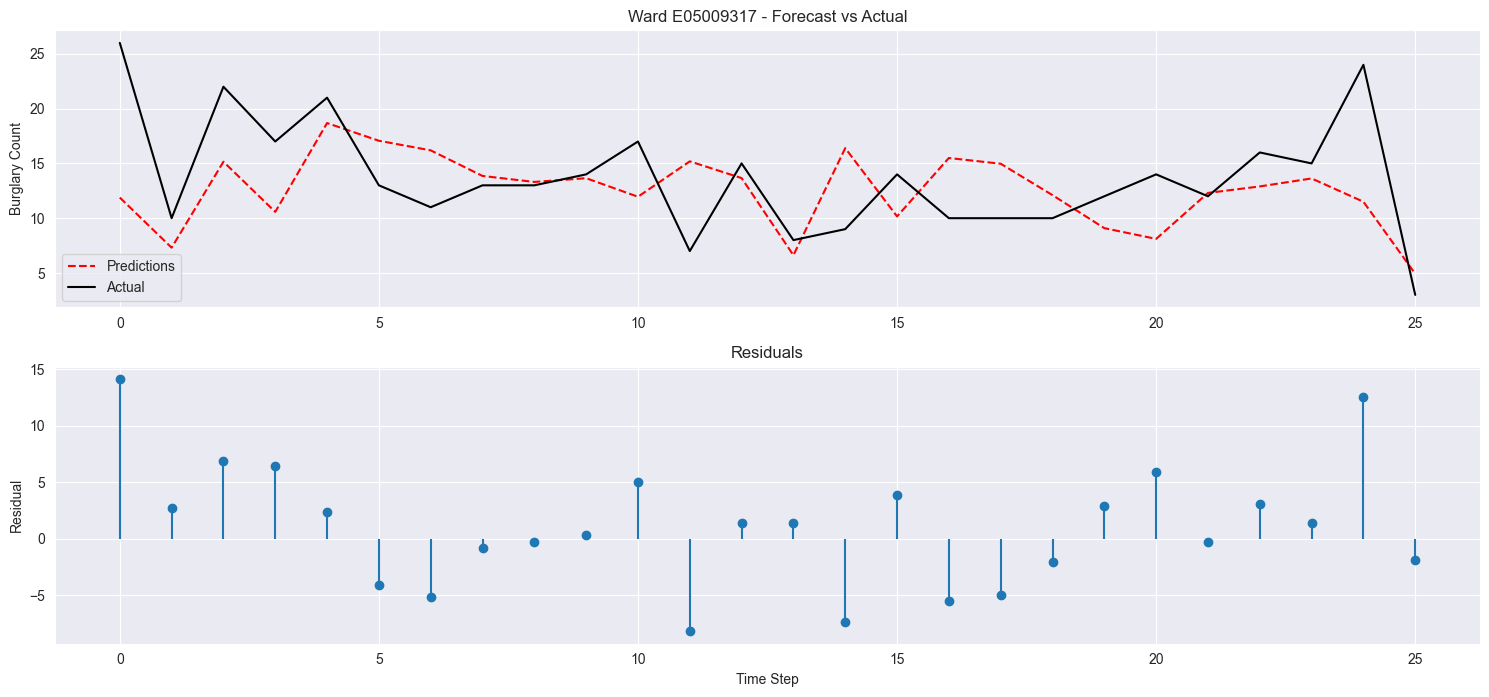


Ward E05009317 Metrics:
MAE: 4.27
RMSE: 5.49
Avg Residual: 1.13



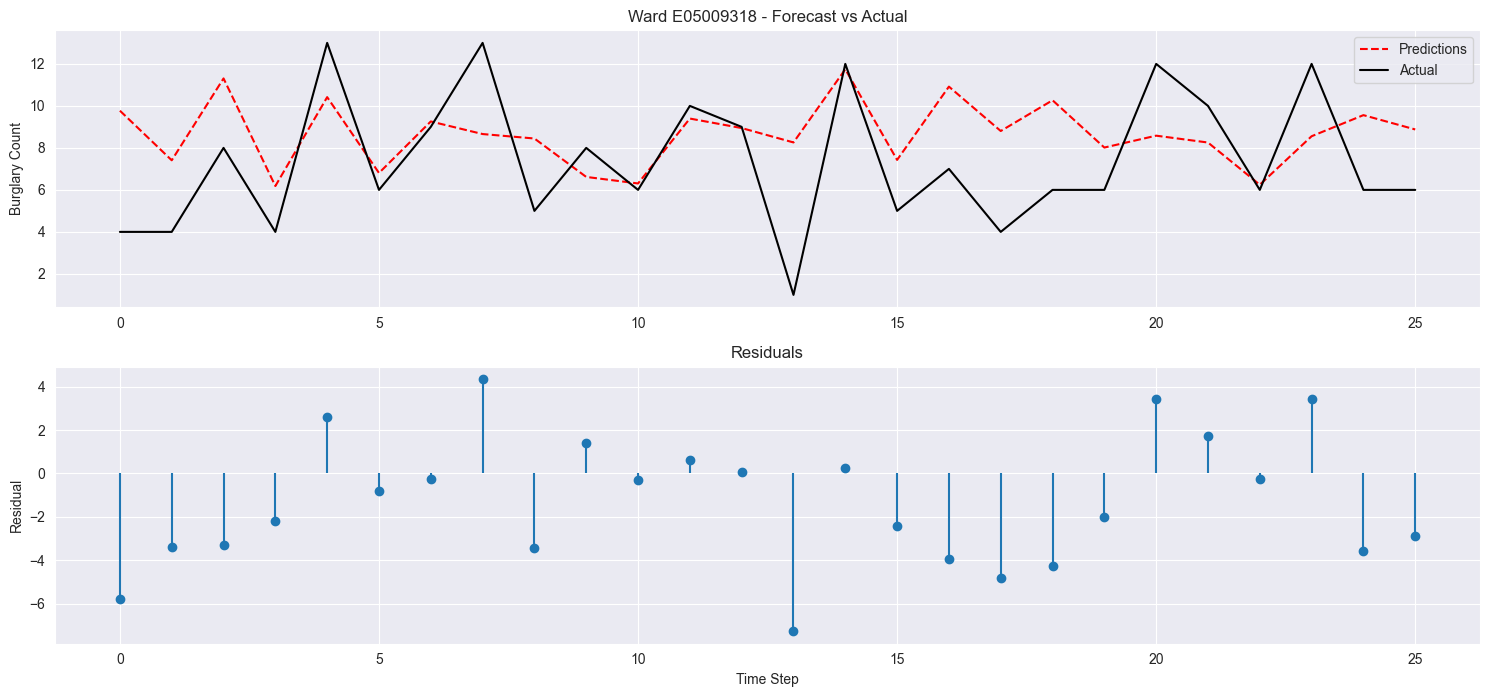


Ward E05009318 Metrics:
MAE: 2.64
RMSE: 3.21
Avg Residual: -1.27



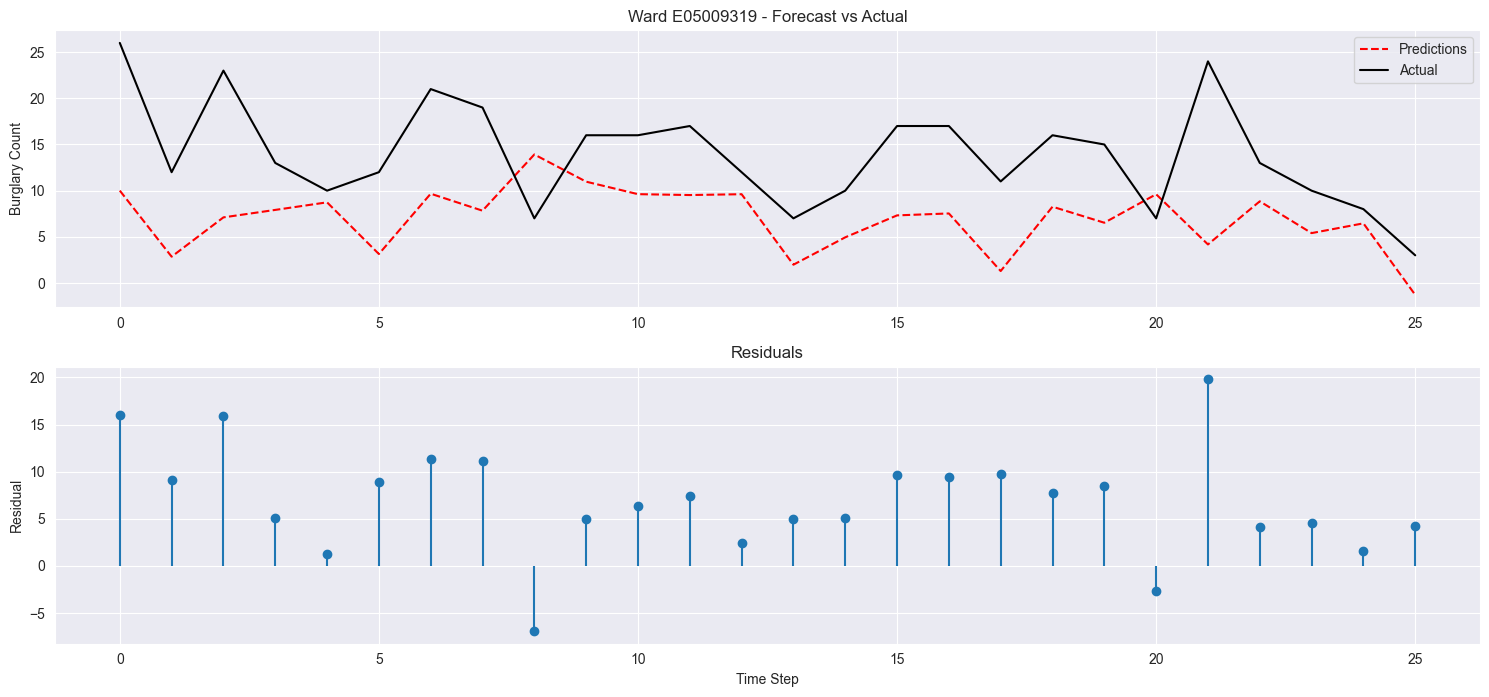


Ward E05009319 Metrics:
MAE: 7.66
RMSE: 8.87
Avg Residual: 6.92



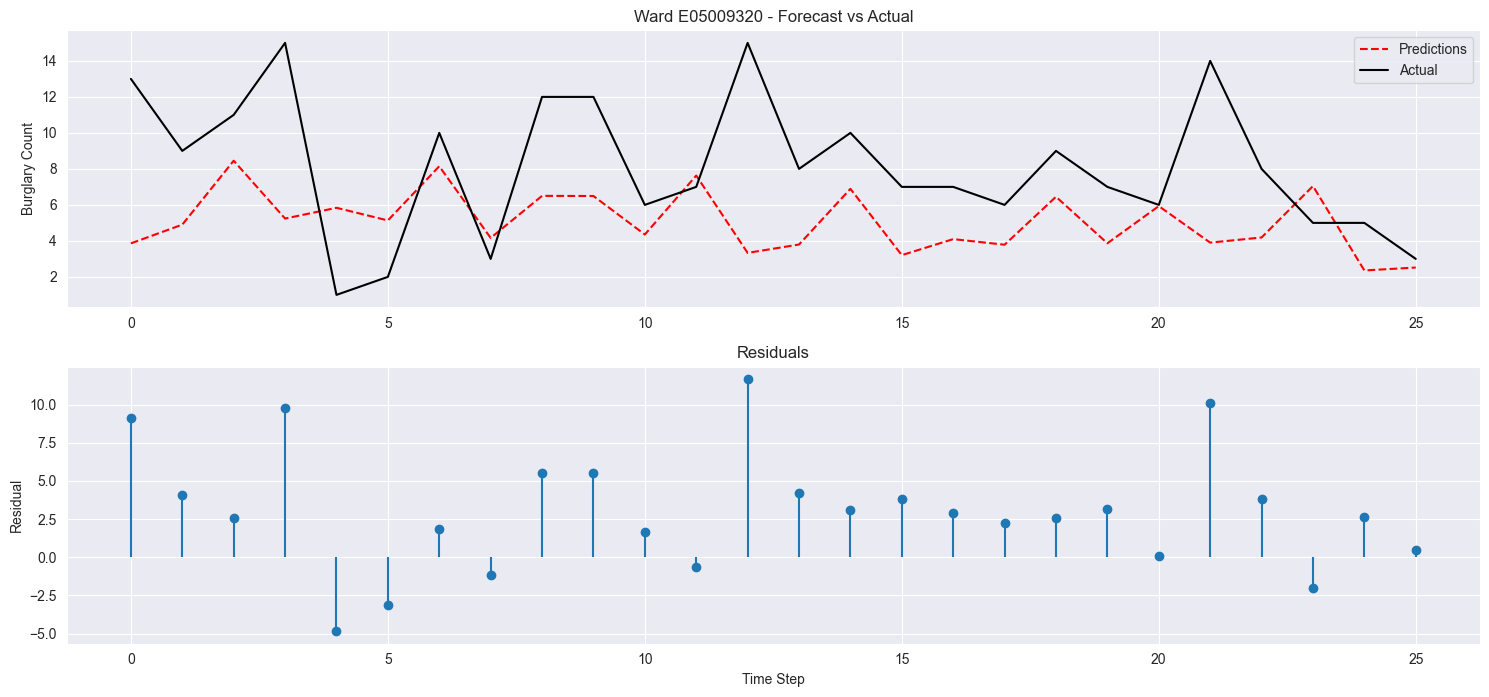


Ward E05009320 Metrics:
MAE: 3.94
RMSE: 4.96
Avg Residual: 3.03



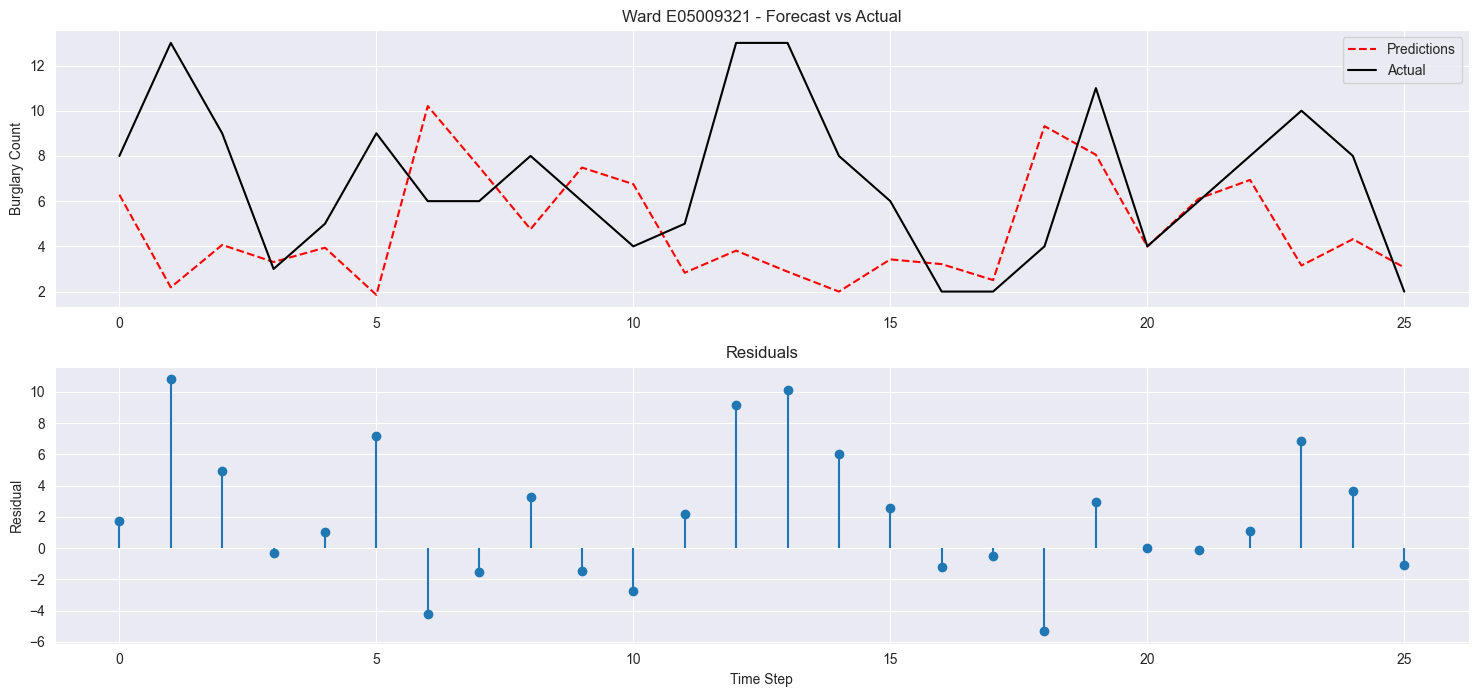


Ward E05009321 Metrics:
MAE: 3.54
RMSE: 4.69
Avg Residual: 2.12



In [35]:
def plot_ward_diagnostics(result):
    """Visualize model performance for a single ward"""
    plt.figure(figsize=(15, 10))

    # Time series plot
    plt.subplot(3, 1, 1)
    plt.plot(result['predicted'], 'r--', label='Predictions')
    plt.plot(result['actual'], 'k-', label='Actual')
    plt.title(f"Ward {result['ward_code']} - Forecast vs Actual")
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)

    # Residual plot
    plt.subplot(3, 1, 2)
    plt.stem(result['residuals'], basefmt=' ')
    plt.title('Residuals')
    plt.xlabel('Time Step')
    plt.ylabel('Residual')
    plt.grid(True)

    # # ACF of residuals
    # plt.subplot(3, 1, 3)
    # plot_acf(result['residuals'], lags=20, alpha=0.05)
    # plt.title('Residual Autocorrelation')
    # plt.xlabel('Lag')
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

# Generate diagnostics for first 5 wards
for res in results[:5]:
    plot_ward_diagnostics(res)
    print(f"\nWard {res['ward_code']} Metrics:")
    print(f"MAE: {mean_absolute_error(res['actual'], res['predicted']):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(res['actual'], res['predicted'])):.2f}")
    print(f"Avg Residual: {np.mean(res['residuals']):.2f}\n")

In [36]:
# Collect ward-level metrics
metrics = []
for res in results:
    metrics.append({
        'ward': res['ward_code'],
        'mae': mean_absolute_error(res['actual'], res['predicted']),
        'rmse': np.sqrt(mean_squared_error(res['actual'], res['predicted'])),
        'mean_residual': np.mean(res['residuals']),
        'residual_std': np.std(res['residuals'])
    })

metrics_df = pd.DataFrame(metrics)

# Print summary statistics
print("\nModel Performance Summary:")
print(f"Average Ward MAE: {metrics_df['mae'].mean():.2f}")
print(f"Average Ward RMSE: {metrics_df['rmse'].mean():.2f}")
print(f"Wards with Positive Bias: {(metrics_df['mean_residual'] > 0).sum()}")
print(f"Wards with Negative Bias: {(metrics_df['mean_residual'] < 0).sum()}")


Model Performance Summary:
Average Ward MAE: 3.14
Average Ward RMSE: 3.92
Wards with Positive Bias: 431
Wards with Negative Bias: 247
